In [601]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio, display
from warnings import warn

from mel import butter_bandpass_filter, pretty_spectrogram, invert_pretty_spectrogram
from mel import create_mel_filter, make_mel, mel_to_spectrogram


class AudioFile:
    
    def __init__(self, dataset='train', instrument='keyboard_acoustic', file_number=27):
        """
        Arguments:
        dataset - str - Nsynth dataset folder (train, valid, test)
        instrument - str - one of:
            keyboard_acoustic
            guitar_acoustic
        file_number - int - index of the file in the dataset 
        """
        data_dir =  Path(f'../data/raw/nsynth-{dataset}/')
        examples = json.load(open(data_dir/'examples.json'))
        instruments = pd.Series(list(examples.keys()))
        file = Path(
            instruments[instruments.str.startswith(instrument)].iloc[file_number] + '.wav'
        )
        self.info = examples[file.stem]
        self.filepath = data_dir/'audio'/file.name
        
#         # Print unique instruments
#         re_find_instrument = partial(re.findall, '^.*?\d')
#         unique_instruments = instruments.apply(re_find_instrument).str[0].str[:-2].unique()
#         print(unique_instruments)

    def load_audio(self, start=0, end=-1, bandpass=None):
        """ Load audio file"""
        self.sampling_rate, self.audio = wavfile.read(self.filepath)
        self.nyquist = self.sampling_rate // 2
        duration = self.audio.shape[0] / self.sampling_rate # in seconds
        # Clip duration
        if end != -1:
            if start < end <= duration:
                end = int(end * sampling_rate)
            else:
                warn(f'End set to {duration}')
                end = -1
        if start != 0:
            if 0 < start < duration:
                start = int(start * sampling_rate)
            else:
                warn(f'Start set to 0')
                start = 0
        self.audio = self.audio[start:end]
        self.duration = self.audio.shape[0] / self.sampling_rate
        # Bandpass filter
        if bandpass:
            self.audio = butter_bandpass_filter(self.audio, *bandpass, self.sampling_rate, order=4)
    
            
    def plot_audio(self):
        """ Plot audio waveform """
        time = np.linspace(0., self.duration, self.audio.shape[0])
        plt.figure(figsize=(10, 3))
        plt.plot(time, self.audio)
        plt.xlim(time.min(), time.max())
        plt.ylabel('Amplitude')
        plt.xlabel('Time (s)');
        plt.tight_layout()
        plt.show()

    def play_audio(self):
        """ Create widget which plays audio """
        display(Audio(self.audio, rate=self.sampling_rate))
    
    # Spectrograms
    def audio_to_spectrogram(self, time_intervals=1, spec_thresh=4):
        """
        Stolen from: https://timsainburg.com/python-mel-compression-inversion.html

        Args:
            time_intervals: how many intervals to slide the window along (in time)   
            spec_thresh: threshold for spectrograms (lower filters out more noise)
        """
        # FFT parameters - fft resolution is maximised across the frequency domain
        self.time_intervals = time_intervals
        fft_size = (self.audio.shape[0] // 2) * 2
        step_size = fft_size // self.time_intervals
        # Create spectrogram
        self.spectrogram = pretty_spectrogram(
            self.audio.astype("float64"),
            fft_size=fft_size,
            step_size=step_size,
            log=True,
            thresh=spec_thresh,
        )

    def spectrogram_to_audio(self, spectrogram, time_intervals=1):
        """
        Convert spectrogram to audio
        """
        fft_size = spectrogram.shape[1] * 2
        step_size = fft_size // self.time_intervals
        recovered_audio = invert_pretty_spectrogram(
            spectrogram,
            fft_size=fft_size,
            step_size=step_size,
            log=True,
            n_iter=10
        )
        display(Audio(recovered_audio, rate=self.sampling_rate))
        
    def plot_spectrogram(self, spectrogram, title='', max_freq=None, figsize=(10, 4)):
        """
        Plots a spectrogram
        """
        if max_freq is None:
            ylim = self.spectrogram.shape[1]
            max_freq = self.nyquist
        else:
            ylim = int(self.spectrogram.shape[1] * max_freq / self.nyquist)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        cax = ax.matshow(
            spectrogram.T[:ylim],
            interpolation="nearest",
            aspect="auto",
            cmap=plt.cm.afmhot,
            origin="lower",
            extent = [0, 1, 0, max_freq]
        )
        fig.colorbar(cax)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    # Convolutions
    def _get_harmonic_groups(self):
        """
        Create groups of harmonic frequencies to unwrap the spectrogram
        """
        max_freq = self.spectrogram.shape[1]
        self.harmonic_groups = []
        for freq in list(range(1, max_freq//2, 2)):
            neighbours = []
            i = 0
            next_freq = freq
            while next_freq <= max_freq+1:
                neighbours.append(next_freq-1)
                i+=1
                next_freq = freq * (2**i)
            self.harmonic_groups.append(neighbours)

    def convolve_spectrogram(self):
        """
        Unwrap the spectrogram_slice, apply 1-D conv and wrap it back up
        """
        self._get_harmonic_groups()
        self.spectrogram_conv = np.ones(self.spectrogram.shape)[:, ::2] # * -8
        mask = [1, 1]
        for t in range(self.spectrogram.shape[0]):
            # Time slice to apply convolution to
            spectrogram_slice = self.spectrogram[t]
            # Convolve each group of harmonics
            harmonic_convs = []
            for group in self.harmonic_groups:
                harmonic_amplitudes = spectrogram_slice[group]
                harmonic_convs = np.convolve(mask, harmonic_amplitudes, mode='valid')
                self.spectrogram_conv[t, group[:-1]] = harmonic_convs

In [602]:
piano = AudioFile('train', 'keyboard_acoustic', 27)
guitar = AudioFile('test', 'guitar_acoustic', 6)

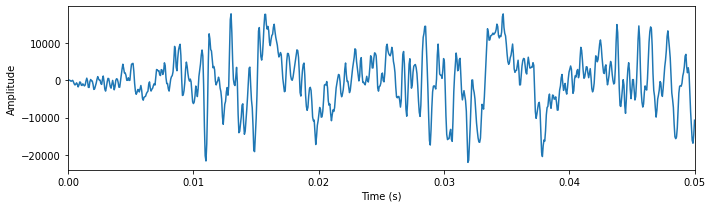

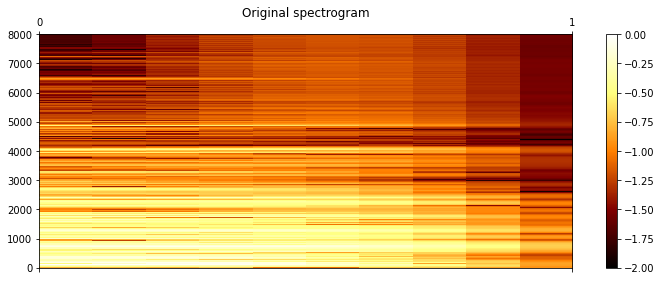

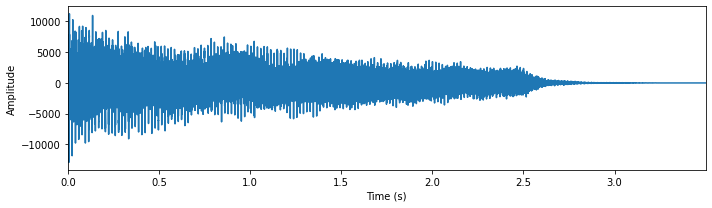

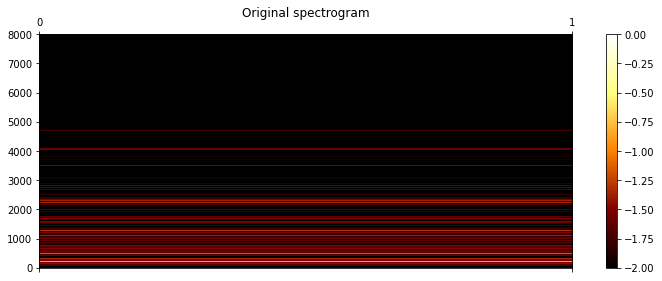

In [610]:
for (start, end, intervals) in [(0, 0.05, 10), (0.5, -1, 1)]:
    # Load audio
    piano.load_audio(start, end)
    piano.plot_audio()
    piano.play_audio()
    # Create spectrogram
    piano.audio_to_spectrogram(time_intervals=intervals)
    piano.plot_spectrogram(piano.spectrogram/2, 'Original spectrogram')
    piano.spectrogram_to_audio(piano.spectrogram)

# Convolve spectrogram
# piano.convolve_spectrogram()
# piano.plot_spectrogram(piano.spectrogram_conv)
# piano.spectrogram_to_audio(piano.spectrogram_conv)

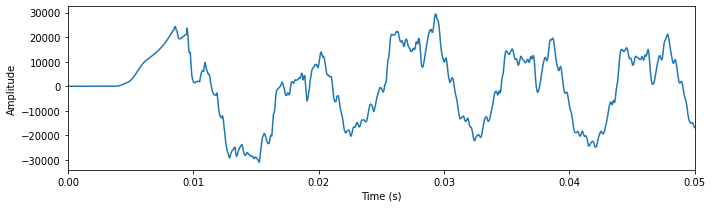

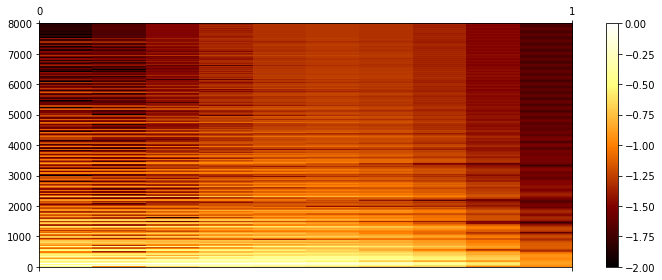

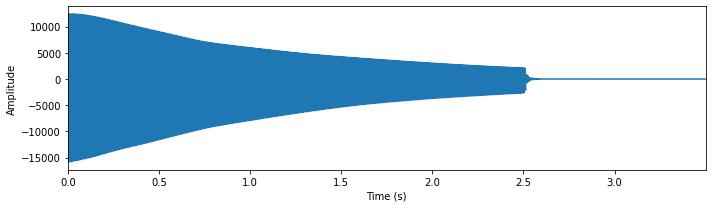

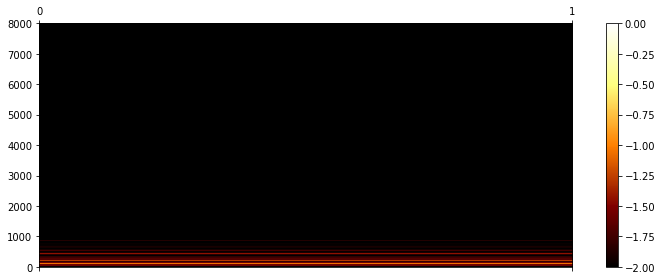

In [609]:
for (start, end, intervals) in [(0, 0.05, 10), (0.5, -1, 1)]:
    # Load audio
    guitar.load_audio(start, end)
    guitar.plot_audio()
    guitar.play_audio()
    # Create spectrogram
    guitar.audio_to_spectrogram(time_intervals=intervals)
    guitar.plot_spectrogram(guitar.spectrogram/2)
    guitar.spectrogram_to_audio(guitar.spectrogram)

# Convolve spectrogram
# guitar.convolve_spectrogram()
# guitar.plot_spectrogram(guitar.spectrogram_conv)
# guitar.spectrogram_to_audio(guitar.spectrogram_conv)

# Analysis

The nylon guitar:
- Is composed of multiple harmonic sine waves (and a few distortions around the harmonics)
- Has additional energy in the lower frequencies below the fundamental frequency
- These lower frequencies don't have any harmonics

The piano:
- Has a lot of energy between octave harmonics
- Has more energy around the 3rd and 4th harmonics than the fundamental
- These higher frequencies don't have any harmonics

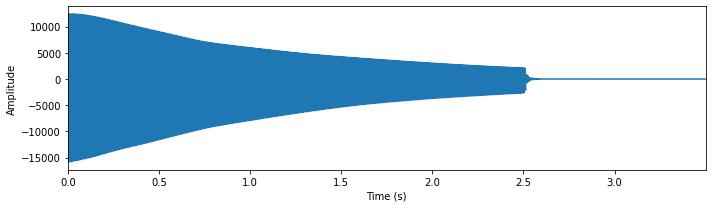

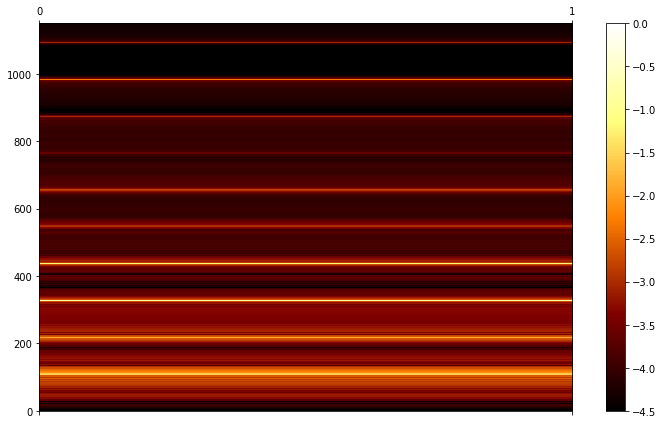

In [615]:
max_freq = 1150 # Note A2 is at 110hz
# Load audio
guitar.load_audio(start=0.5)#, bandpass=(10, 150))#max_freq))
guitar.plot_audio()
guitar.play_audio()
# Create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4.5)
guitar.plot_spectrogram(guitar.spectrogram, max_freq=max_freq, figsize=(10, 6))
guitar.spectrogram_to_audio(guitar.spectrogram)

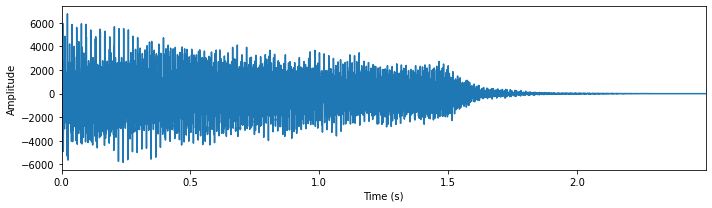

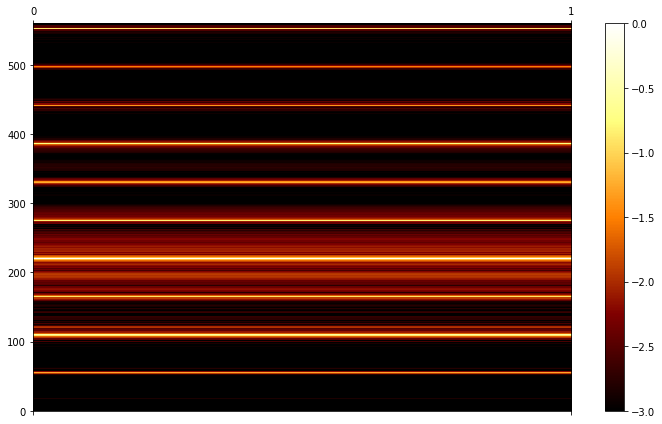

In [616]:
max_freq = 560 # Note A1 is at 55hz
# Load audio
piano.load_audio(start=1.5)#, bandpass=(10, 2400))#max_freq))
piano.plot_audio()
piano.play_audio()
# Create spectrogram
piano.audio_to_spectrogram(spec_thresh=3)
piano.plot_spectrogram(piano.spectrogram, max_freq=max_freq, figsize=(10, 6))
piano.spectrogram_to_audio(piano.spectrogram)